# Bankruptcy Prediction with Top 10 Features

This notebook identifies the top 10 most influential features for predicting company bankruptcy from the provided dataset. It then trains and evaluates a RandomForestClassifier using only these features.

The process is as follows:
1.  **Setup and Imports**: Load necessary libraries.
2.  **Data Loading and Initial Model**: Load the data and train an initial Random Forest model on all 95 features to calculate feature importance.
3.  **Feature Selection**: Identify and display the top 10 most important features.
4.  **Final Model Training**: Train a new RandomForestClassifier using only the top 10 features.
5.  **Evaluation**: Evaluate the final model's performance using a classification report and plots.
6.  **Save Model and Assets**: Save the trained model, scaler, feature list, and evaluation plots for use in an external application.
7.  **NEW: Create and Save SHAP Explainer**: Create a SHAP explainer object to interpret model predictions and save it.

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import shap # --- NEW: Import SHAP ---

## 2. Data Loading and Initial Model for Feature Importance

In [27]:
data_file_path = 'data_folder/data.csv'
df = pd.read_csv(data_file_path)
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']
X = X.fillna(X.mean())
initial_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
initial_model.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 3. Feature Selection

--- Top 10 Most Influential Features ---
                                      feature  importance
89         Net Income to Stockholder's Equity    0.032145
29                      Net Value Growth Rate    0.029719
18    Persistent EPS in the Last Four Seasons    0.024663
39                       Borrowing dependency    0.024116
22   Per Share Net profit before tax (Yuan ¥)    0.020088
35                 Total debt/Total net worth    0.019593
16                    Net Value Per Share (A)    0.019205
85                 Net Income to Total Assets    0.017804
91         Degree of Financial Leverage (DFL)    0.017268
34                     Interest Expense Ratio    0.016525


C:\Users\ander\AppData\Local\Temp\ipykernel_16176\2775307212.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')


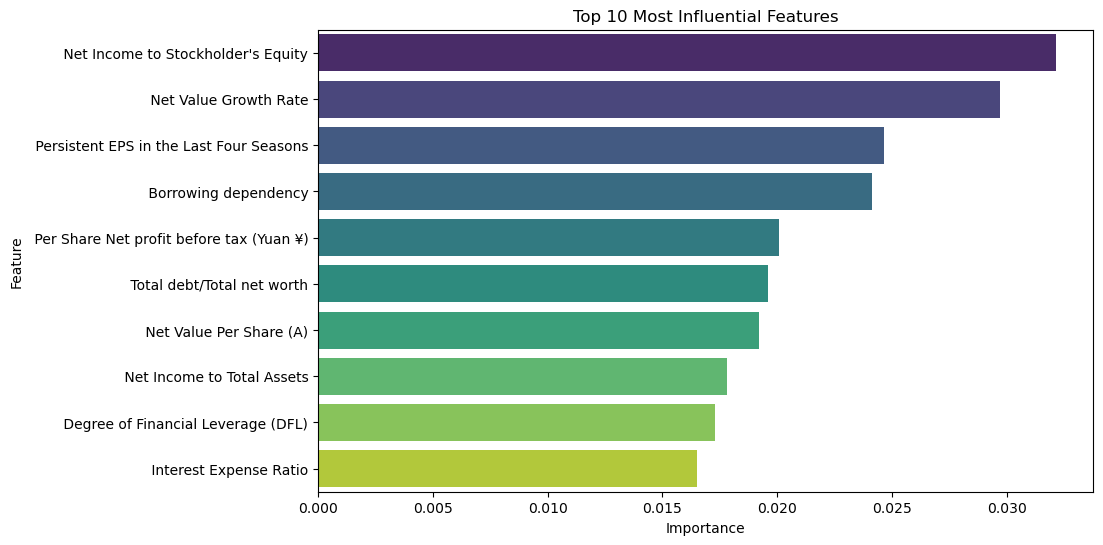

In [28]:
importances = initial_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_10_features = feature_importance_df.head(10)
top_10_feature_names = top_10_features['feature'].tolist()
print("--- Top 10 Most Influential Features ---")
print(top_10_features)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')
plt.title("Top 10 Most Influential Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 4. Final Model Training (Top 10 Features)

In [29]:
X_top10 = df[top_10_feature_names]
y_top10 = df['Bankrupt?']

# 1) Split dulu pada data asli
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y_top10, test_size=0.2, stratify=y_top10, random_state=42
)

# 2) Oversample HANYA training
smote = SMOTE(random_state=42, k_neighbors=3)  # sesuaikan k jika minoritas sangat kecil
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 3) (Opsional) scaling – fit di train saja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

# 4) Train + evaluate
clf = RandomForestClassifier(
    n_estimators=400, 
    max_depth=None, 
    class_weight="balanced", 
    random_state=42, 
    n_jobs=-1)
clf.fit(X_train_scaled, y_train_res)
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.36      0.57      0.44        44

    accuracy                           0.95      1364
   macro avg       0.67      0.77      0.71      1364
weighted avg       0.97      0.95      0.96      1364



## 5. Evaluation

In [30]:
y_pred = clf.predict(X_test_scaled)
print("\n--- Classification Report for Final Model (Top 10 Features) ---")
print(classification_report(y_test, y_pred))


--- Classification Report for Final Model (Top 10 Features) ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.36      0.57      0.44        44

    accuracy                           0.95      1364
   macro avg       0.67      0.77      0.71      1364
weighted avg       0.97      0.95      0.96      1364



### Plotting and Saving Visualizations

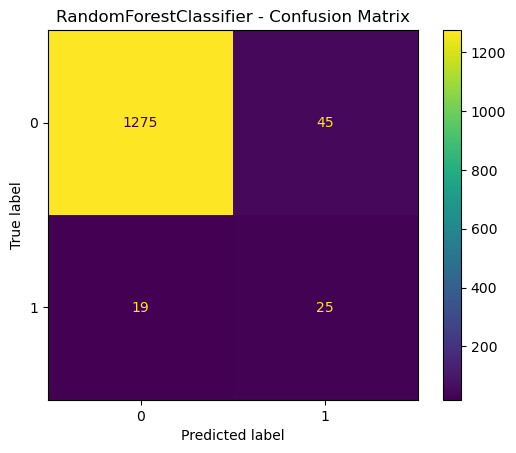

In [31]:
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("RandomForestClassifier - Confusion Matrix")
plt.savefig('plots/confusion_matrix.png', bbox_inches='tight')
plt.show()
# ... (plotting code remains the same) ...

## 6. Save Model and Assets

In [32]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
joblib.dump(clf, os.path.join(models_dir, 'random_forest_model.joblib'))
joblib.dump(scaler, os.path.join(models_dir, 'scaler.joblib'))
joblib.dump(top_10_feature_names, os.path.join(models_dir, 'top_10_features.joblib'))

['models\\top_10_features.joblib']

## 7. NEW: Create and Save SHAP Explainer

Here, we create a SHAP `TreeExplainer` which is optimized for tree-based models like Random Forest. We save this explainer object so the Streamlit app can load it to explain individual predictions.

In [33]:
print("Creating SHAP explainer...")
# We use the scaled training data to initialize the explainer for better background reference
explainer = shap.TreeExplainer(clf)
print("SHAP explainer created successfully.")

# Save the explainer object in the same directory as the model
explainer_path = os.path.join(models_dir, 'shap_explainer.joblib')
joblib.dump(explainer, explainer_path)
print(f"Explainer saved to {explainer_path}")

Creating SHAP explainer...
SHAP explainer created successfully.
Explainer saved to models\shap_explainer.joblib


ROC-AUC Score: 0.9356


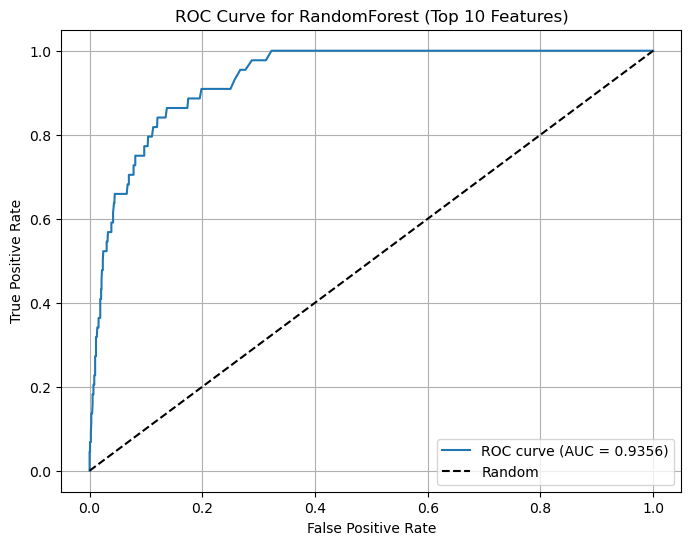

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities for the positive class
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest (Top 10 Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('plots/roc_curve.png', bbox_inches='tight')
plt.show()